# TensorFlow Dataset

The tf.data API enables you to build complex input pipelines from simple, reusable pieces. For example, the pipeline for an image model might aggregate data from files in a distributed file system, apply random perturbations to each image, and merge randomly selected images into a batch for training. The pipeline for a text model might involve extracting symbols from raw text data, converting them to embedding identifiers with a lookup table, and batching together sequences of different lengths. The tf.data API makes it possible to handle large amounts of data, read from different data formats, and perform complex transformations.

The tf.data API introduces a tf.data.Dataset abstraction that represents a sequence of elements, in which each element consists of one or more components. For example, in an image pipeline, an element might be a single training example, with a pair of tensor components representing the image and its label.

### Combine tf.data.Datasets and @tf.function

When iterating over training data that fits in memory, feel free to use regular Python iteration. Otherwise, tf.data.Dataset is the best way to stream training data from disk. Datasets are iterables (not iterators), and work just like other Python iterables in Eager mode. You can fully utilize dataset async prefetching/streaming features by wrapping your code in tf.function(), which replaces Python iteration with the equivalent graph operations using AutoGraph.  See: https://www.tensorflow.org/guide/effective_tf2

There are two distinct ways to create a dataset:

    A data source constructs a Dataset from data stored in memory or in one or more files.

    A data transformation constructs a dataset from one or more tf.data.Dataset objects.

Reference: 
+ https://www.tensorflow.org/guide/data
+ https://www.tensorflow.org/tutorials/load_data/text
+ https://www.tensorflow.org/tutorials/load_data/pandas_dataframe
+ https://www.tensorflow.org/tutorials/load_data/images

In [1]:
# Python 3.7.3
############################################
# INCLUDES
############################################
#libraries specific to this example
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# seed the pseudorandom number generator
from random import seed
from random import random
from random import randint

#a set of libraries that perhaps should always be in Python source
import os 
import datetime
import sys
import gc
import getopt
import inspect
import math
import warnings
import types

#Data Science Libraries
import numpy as np
import pandas as pd
import scipy as sp
import scipy.ndimage

#Plotting libraries
import matplotlib as matplt
import matplotlib.pyplot as plt

#a darn useful library for creating paths and one I recommend you load to your environment
from pathlib import Path

# can type in the python console `help(name of function)` to get the documentation
from pydoc import help                          

#Import a custom library, in this case a fairly useful logging framework
debug_lib_location = Path("./")
sys.path.append(str(debug_lib_location))
import debug

warnings.filterwarnings('ignore')               # don't print out warnings


root_location="." + os.sep + "data";

# Eager Execution

What is Eager Execution?

    “A NumPy-like library for numerical computation with support for GPU acceleration and automatic differentiation, and a flexible platform for machine learning research and experimentation.”
    
**Features of Eager Execution?**

+ It is compatible with native Python debugging tools
+ Error logging is immediate
+ Native Python control flow i.e loops and recursions
+ Eager execution simplifies your code
+ Back propagation is built in to eager execution   

TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, without building graphs: operations return concrete values instead of constructing a computational graph to run later. This makes it easy to get started with TensorFlow and debug models, and it reduces boilerplate as well. To follow along with this guide, run the code samples below in an interactive python interpreter.

Eager execution is a flexible machine learning platform for research and experimentation, providing:

" *An intuitive interface—Structure your code naturally and use Python data structures. Quickly iterate on small models and small data.  Easier debugging—Call ops directly to inspect running models and test changes. Use standard Python debugging tools for immediate error reporting.  Natural control flow—Use Python control flow instead of graph control flow, simplifying the specification of dynamic models.* "

Eager execution supports most TensorFlow operations and GPU acceleration.


Reference:
+ https://medium.com/coding-blocks/eager-execution-in-tensorflow-a-more-pythonic-way-of-building-models-e461810618c8

In [2]:
#Determine if Eager Execution is Enabled
tf.executing_eagerly()

True

In [3]:
############################################
#JUPYTER NOTEBOOK OUTPUT CONTROL / FORMATTING
############################################
#set floating point to 4 places to things don't run loose
pd.options.display.float_format = '{:,.4f}'.format
np.set_printoptions(precision=4)

# Variable declaration

In [4]:
############################################
# GLOBAL VARIABLES
############################################
DEBUG = 1                            #General ledger output so you know what's happening.
DEBUG_DATA = 1                       #Extremely verbose output, change to zero (0) to supress the volume of output.

# CODE CONSTRAINTS
VERSION_NAME    = "TensorFlowDataset"
VERSION_ACRONYM = "ML-TFDS"
VERSION_MAJOR   = 0
VERSION_MINOR   = 0
VERSION_RELEASE = "0c"
VERSION_TITLE   = VERSION_NAME + " (" + VERSION_ACRONYM + ") " + str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE) + " generated SEED."

ENCODING  ="utf-8"
############################################
# GLOBAL CONSTANTS
############################################

############################################
# APPLICATION VARIABLES
############################################

############################################
# GLOBAL CONFIGURATION
############################################
os.environ['PYTHONIOENCODING']=ENCODING


## General Function Declaration

In [5]:
############################################
# WARNING / ERROR Management
############################################
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


############################################
# FUNCTIONS
############################################

def prototype(incMonth):

    debug.msg_info("Entering {}.{}".format(__name__, inspect.stack()[0][3]))
    debug.msg_info("The month you passed in was " + str(incMonth))
    debug.msg_info("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))
    return 1

def lib_diagnostics():
    debug.msg_debug("System version    #:{:>12}".format(sys.version))
    try:
        netcdf4_version_info = nc.getlibversion().split(" ")
        debug.msg_debug("netCDF4 version   #:{:>12}".format(netcdf4_version_info[0]))
    except:
        print("NetCDF4 lib not present.")
    debug.msg_debug("Matplotlib version#:{:>12}".format(matplt.__version__))
    debug.msg_debug("Numpy version     #:{:>12}".format(np.__version__))
    debug.msg_debug("Pandas version    #:{:>12}".format(pd.__version__))
    debug.msg_debug("SciPy version     #:{:>12}".format(sp.__version__))
    debug.msg_debug("TensorFlow version#:{:>12}".format(tf.__version__))
    return

def get_full_version():

    resultant = str(VERSION_NAME) + "  v" + str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE)
    return resultant

def get_version():

    resultant = str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE)
    return resultant

def printversion():

    print(get_full_version())

def printusage():

    print("")
    printversion()
    print("  -v, --version    prints the version of this software package.")
    print("")
    print("  * - indicates required argument.")

######################################################################
#Support routines to see columns in DataFrames
######################################################################
def show_columns_plain(inc_ary):
    new_ary = []
    for col in inc_ary:
        new_ary.append(np.char.lower(col))
    new_ary.sort
    myOutputString = " "
    for col in new_ary:
        myOutputString = myOutputString + " " + str(col)
    return myOutputString

def show_columns_true(inc_ary):
    new_ary = []
    for col in inc_ary:
        new_ary.append(col)
    new_ary.sort
    myOutputString = " "
    for col in new_ary:
        myOutputString = myOutputString + " " + str(col)
    return myOutputString

######################################################################
#Input Validation
######################################################################
# valid string:
#  We don't want the following:
#   - at the start of the file name (might be construed as a switch)
#  $, &, |, ;, <, >, `, !, *, ", \ (to start with)
###
def validstring(testsubject):

    if testsubject[0] == "-":
        return 0
    elif "$" in testsubject or "&" in testsubject or "|" in testsubject:
        return 0
    elif ";" in testsubject or "`" in testsubject or "!" in testsubject:
        return 0
    elif "*" in testsubject or '"' in testsubject or "\\" in testsubject:
        return 0
    else:
        return 1
        

In [6]:
# %load ./libs.py
#Title:     Displays the libraries in current use.
#Objective: Invocation is intended as function calls within another program.
#Assumptions:
#           1. Should be stored in standardized location such as:
#                      /p/home/{user_name}/usr/PYTHONLIB
#           2. Developer loads the module (Jupyter Lab).
#Pre-Requisites:
#           1. Python v3.*
#           2. Jupyter Lab / Notebook (%load libs.py)
#Usage:
#       %load libs.py
#       find_loaded_modules().HTML
#
#Version History:
# ------------------------------------------------------------------------
# Version   Date       Modification                              Author
# ------------------------------------------------------------------------
# 1.0       2020/04/29 Inception                                 Radiance
# ------------------------------------------------------------------------
# ------------------------------------------------------------------------


#######################################################################
#LIBRARIES
#######################################################################
import os
import types

def module_version(mod):
    '''Return version string for module *mod*, or nothing if
    it doesn't have a "version" or "__version__" attribute.'''
    version = []
    if hasattr(mod, '__dict__'):
        keys = []
        for key in mod.__dict__.keys():
            if key.lower() == 'version' or key.lower() == '__version__':
                v = mod.__dict__[key]
                if (str):
                    if isinstance(v, str):
                        version.append(v)
                else:
                    version.append("No version")
        if keys:
            print (mod, keys)
    if version:
        return ', '.join(version)
    else:
        return ''

def find_loaded_modules(only_versioned_modules=True):

    def list_of_lists_to_HTML(lists, header_row=None):
        '''Convert a list of a list of strings to a HTML table.'''
        s = '<table>'
        if header_row:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<th>%s</th>' % item for item in header_row])
            s += '\n\t</tr>'
        for inner_list in lists:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<td>%s</td>' % item for item in inner_list])
            s += '\n\t</tr>'
        s += '\n</table>'
        return s
    
    class LoadedModules(list):
        '''Very simple wrapper for a list of lists of strings, with an attribute
        for display in IPython Notebooks.'''
        def __init__(self, *args, **kwargs):
            list.__init__(self, *args, **kwargs)
            
        @property
        def HTML(self):
            from IPython.display import HTML
            return HTML(
                    list_of_lists_to_HTML(
                            self, header_row=['Name', 'Version']))
                    
    objs = LoadedModules()
    for i, mod in enumerate(globals().values()):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__'):
                name = mod.__name__
            else:
                name = ''
            
            version = module_version(mod)
            
            objs.append([mod.__name__, version])
    objs.sort(key=lambda r: r[0])
    return objs


In [7]:
find_loaded_modules().HTML

Name,Version
builtins,
builtins,
datetime,
debug,
gc,
getopt,
inspect,
math,
matplotlib,3.4.2
matplotlib.pyplot,


# Basic Mechanics

In [8]:
debug.msg_debug("################################################################")
debug.msg_debug(" Dataset Basics")
debug.msg_debug("################################################################")
debug.msg_debug("")

#######################################################################
#TensorFlow.Dataset
#######################################################################
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset

[2022-09-12 13:29:34 CDT]   DEBUG: ################################################################ 
[2022-09-12 13:29:34 CDT]   DEBUG:  Dataset Basics 
[2022-09-12 13:29:34 CDT]   DEBUG: ################################################################ 
[2022-09-12 13:29:34 CDT]   DEBUG:  


<TensorSliceDataset shapes: (), types: tf.int32>

# Why did we turn on Eager Execution earlier?

Because using some aspects of the tf.Dataset API requires it be enabled.

In [9]:
#######################################################################
#TensorFlow.Dataset - accessing the data
#######################################################################
for elem in dataset:
    debug.msg_debug("DataStructure: " + str(elem))
    debug.msg_debug("Just the value:" + str(elem.numpy()))

[2022-09-12 13:29:34 CDT]   DEBUG: DataStructure: tf.Tensor(8, shape=(), dtype=int32) 
[2022-09-12 13:29:34 CDT]   DEBUG: Just the value:8 
[2022-09-12 13:29:34 CDT]   DEBUG: DataStructure: tf.Tensor(3, shape=(), dtype=int32) 
[2022-09-12 13:29:34 CDT]   DEBUG: Just the value:3 
[2022-09-12 13:29:34 CDT]   DEBUG: DataStructure: tf.Tensor(0, shape=(), dtype=int32) 
[2022-09-12 13:29:34 CDT]   DEBUG: Just the value:0 
[2022-09-12 13:29:34 CDT]   DEBUG: DataStructure: tf.Tensor(8, shape=(), dtype=int32) 
[2022-09-12 13:29:34 CDT]   DEBUG: Just the value:8 
[2022-09-12 13:29:34 CDT]   DEBUG: DataStructure: tf.Tensor(2, shape=(), dtype=int32) 
[2022-09-12 13:29:34 CDT]   DEBUG: Just the value:2 
[2022-09-12 13:29:34 CDT]   DEBUG: DataStructure: tf.Tensor(1, shape=(), dtype=int32) 
[2022-09-12 13:29:34 CDT]   DEBUG: Just the value:1 


# Dataset Structure

A dataset contains elements that each have the same (nested) structure and the individual components of the structure can be of any type representable by tf.TypeSpec, including tf.Tensor, tf.sparse.SparseTensor, tf.RaggedTensor, tf.TensorArray, or tf.data.Dataset.

The Dataset.element_spec property allows you to inspect the type of each element component. The property returns a nested structure of tf.TypeSpec objects, matching the structure of the element, which may be a single component, a tuple of components, or a nested tuple of components. For example:

In [10]:
#create a 4 x 10 array of randome values
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))

In [11]:
#######################################################################
#TensorFlow.Dataset - accessing the data
#######################################################################
for elem in dataset1:
    debug.msg_debug("DataStructure: " + str(elem))
    debug.msg_debug("Just the value:" + str(elem.numpy()))

[2022-09-12 13:29:34 CDT]   DEBUG: DataStructure: tf.Tensor([0.7833 0.8558 0.5301 0.2505 0.4794 0.2165 0.7069 0.666  0.0169 0.0112], shape=(10,), dtype=float32) 
[2022-09-12 13:29:34 CDT]   DEBUG: Just the value:[0.7833 0.8558 0.5301 0.2505 0.4794 0.2165 0.7069 0.666  0.0169 0.0112] 
[2022-09-12 13:29:34 CDT]   DEBUG: DataStructure: tf.Tensor([0.7417 0.8793 0.8083 0.0526 0.568  0.8071 0.6246 0.8929 0.8242 0.9119], shape=(10,), dtype=float32) 
[2022-09-12 13:29:34 CDT]   DEBUG: Just the value:[0.7417 0.8793 0.8083 0.0526 0.568  0.8071 0.6246 0.8929 0.8242 0.9119] 
[2022-09-12 13:29:34 CDT]   DEBUG: DataStructure: tf.Tensor([0.4654 0.2745 0.4607 0.8814 0.5709 0.36   0.83   0.9356 0.5301 0.4807], shape=(10,), dtype=float32) 
[2022-09-12 13:29:34 CDT]   DEBUG: Just the value:[0.4654 0.2745 0.4607 0.8814 0.5709 0.36   0.83   0.9356 0.5301 0.4807] 
[2022-09-12 13:29:34 CDT]   DEBUG: DataStructure: tf.Tensor([0.982  0.6681 0.9765 0.213  0.2492 0.1873 0.0217 0.5327 0.7591 0.5551], shape=(10,),

In [12]:
#######################################################################
#TensorFlow.Dataset - just dump the array
#######################################################################
for z in dataset1:
  debug.msg_debug(z.numpy())

[2022-09-12 13:29:34 CDT]   DEBUG: [0.7833 0.8558 0.5301 0.2505 0.4794 0.2165 0.7069 0.666  0.0169 0.0112] 
[2022-09-12 13:29:34 CDT]   DEBUG: [0.7417 0.8793 0.8083 0.0526 0.568  0.8071 0.6246 0.8929 0.8242 0.9119] 
[2022-09-12 13:29:34 CDT]   DEBUG: [0.4654 0.2745 0.4607 0.8814 0.5709 0.36   0.83   0.9356 0.5301 0.4807] 
[2022-09-12 13:29:34 CDT]   DEBUG: [0.982  0.6681 0.9765 0.213  0.2492 0.1873 0.0217 0.5327 0.7591 0.5551] 


## Enhanced Complexity

For a more realistic example, try wrapping preprocessing.image.ImageDataGenerator as a tf.data.Dataset.

Note that this would be a beneficial way of loading data for a Covolutionsl Neural Network (CNN) image recognition mechanism.

First download the data:

In [13]:
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

In [14]:
flowers

'/home/cwood/.keras/datasets/flower_photos'

# Images

## Create the image.ImageDataGenerator

In [15]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)

In [16]:
img_gen

In [17]:
images, labels = next(img_gen.flow_from_directory(flowers))

Found 3670 images belonging to 5 classes.
/home/cwood/.keras/datasets/flower_photos/daisy/10391248763_1d16681106_n.jpg
/home/cwood/.keras/datasets/flower_photos/dandelion/13897156242_dca5d93075_m.jpg
/home/cwood/.keras/datasets/flower_photos/daisy/7790614422_4557928ab9_n.jpg
/home/cwood/.keras/datasets/flower_photos/roses/3203779656_3580151ea4_m.jpg
/home/cwood/.keras/datasets/flower_photos/tulips/495094547_fd2d999c44.jpg
/home/cwood/.keras/datasets/flower_photos/roses/15011625580_7974c44bce.jpg
/home/cwood/.keras/datasets/flower_photos/dandelion/146023167_f905574d97_m.jpg
/home/cwood/.keras/datasets/flower_photos/roses/2065522422_cfdd80044a_n.jpg
/home/cwood/.keras/datasets/flower_photos/dandelion/16650892835_9228a3ef67_m.jpg
/home/cwood/.keras/datasets/flower_photos/roses/17702388233_f29dc14834_m.jpg
/home/cwood/.keras/datasets/flower_photos/tulips/8722514702_7ecc68691c.jpg
/home/cwood/.keras/datasets/flower_photos/tulips/4553203984_9cb9312240_n.jpg
/home/cwood/.keras/datasets/flower

If you type `images` or `labels` you'll see decomposed arrays of the images.  Images are arrays of each image and labels is an array of 5 showing zeros where a label doesn't match and a 1 where it does.

In [18]:
debug.msg_debug(str(images.dtype) + " " +str(images.shape) )
debug.msg_debug(str(labels.dtype) + " " +str(labels.shape) )

[2022-09-12 13:29:39 CDT]   DEBUG: float32 (32, 256, 256, 3) 
[2022-09-12 13:29:39 CDT]   DEBUG: float32 (32, 5) 


In [19]:
ds = tf.data.Dataset.from_generator(
    img_gen.flow_from_directory, args=[flowers], 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([32,256,256,3], [32,5])
)

In [20]:
ds

<FlatMapDataset shapes: ((32, 256, 256, 3), (32, 5)), types: (tf.float32, tf.float32)>

## Load images

In [21]:
#######################################################################
#Prep environment
#######################################################################
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [22]:
#######################################################################
#Retrieve images
#######################################################################
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

In [23]:
#######################################################################
#After downloading (218MB), you should now have a copy of the flower photos available.
#The directory contains 5 sub-directories, one per class:
#You could easily construct your own data set 
#######################################################################    
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [24]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

Each directory contains images of that type of flower. Here are some roses:

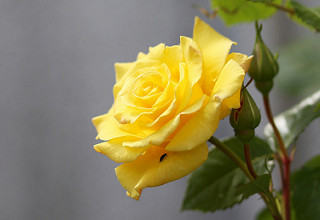

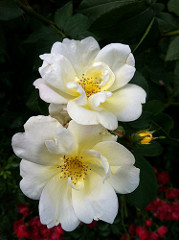

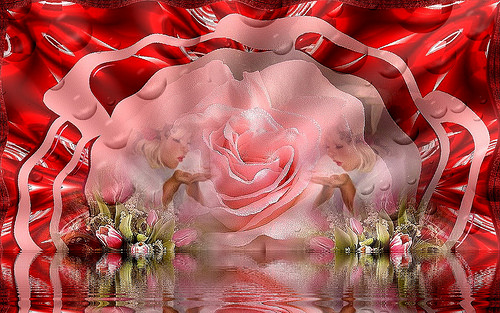

In [25]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

### Load using keras.preprocessing

A simple way to load images is to use tf.keras.preprocessing.

In [26]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [27]:
#Define some parameters for the loader:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [28]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


In [29]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

/home/cwood/.keras/datasets/flower_photos/roses/1392579828_ab5a139052.jpg
/home/cwood/.keras/datasets/flower_photos/dandelion/2697283969_c1f9cbb936.jpg
/home/cwood/.keras/datasets/flower_photos/tulips/16265883604_92be82b973.jpg
/home/cwood/.keras/datasets/flower_photos/dandelion/22190242684_8c3300d4e6.jpg
/home/cwood/.keras/datasets/flower_photos/dandelion/2518321294_dde5aa7c20_m.jpg
/home/cwood/.keras/datasets/flower_photos/dandelion/4572738670_4787a11058_n.jpg
/home/cwood/.keras/datasets/flower_photos/sunflowers/200557977_bf24d9550b.jpg
/home/cwood/.keras/datasets/flower_photos/daisy/2057816617_18448093d0_n.jpg
/home/cwood/.keras/datasets/flower_photos/dandelion/8376558865_19c5cd6fd6_n.jpg
/home/cwood/.keras/datasets/flower_photos/tulips/13509967925_eaaeefa396_m.jpg
/home/cwood/.keras/datasets/flower_photos/roses/16051111039_0f0626a241_n.jpg
/home/cwood/.keras/datasets/flower_photos/dandelion/2620243133_e801981efe_n.jpg
/home/cwood/.keras/datasets/flower_photos/daisy/2087343668_ef4fb

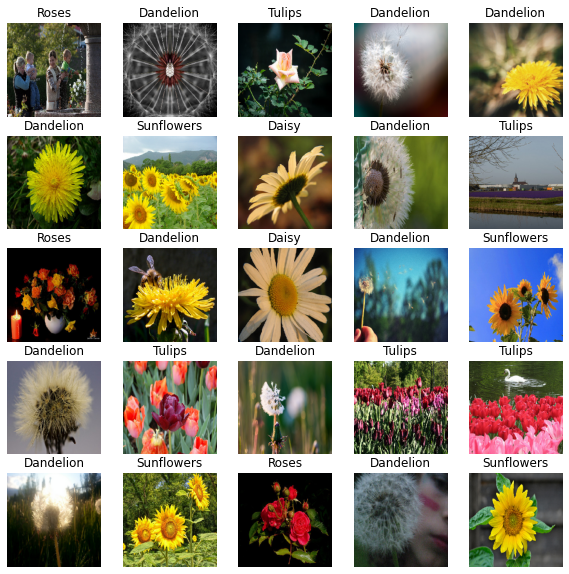

In [30]:
#doesn't work...not sure why
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## Load using tf.data

The above keras.preprocessing method is convienient, but has three downsides:

+ It's slow. See the performance section below.
+ It lacks fine-grained control.
+ It is not well integrated with the rest of TensorFlow.

To load the files as a tf.data.Dataset first create a dataset of the file paths:

In [31]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
for f in list_ds.take(5):
  print(f.numpy())

b'/home/cwood/.keras/datasets/flower_photos/sunflowers/5492906452_80943bfd04.jpg'
b'/home/cwood/.keras/datasets/flower_photos/daisy/2666572212_2caca8de9f_n.jpg'
b'/home/cwood/.keras/datasets/flower_photos/tulips/15275199229_962387f24d.jpg'
b'/home/cwood/.keras/datasets/flower_photos/sunflowers/5043404000_9bc16cb7e5_m.jpg'
b'/home/cwood/.keras/datasets/flower_photos/daisy/5948835387_5a98d39eff_m.jpg'


Write a short pure-tensorflow function that converts a file path to an (img, label) pair:

In [32]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use Dataset.map to create a dataset of image, label pairs:

In [33]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
    
#not working right...not sure why.

Image shape:  (224, 224, 3)
Label:  [False False False False  True]


## Consuming TFRecord data

See Loading TFRecords for an end-to-end example.

The tf.data API supports a variety of file formats so that you can process large datasets that do not fit in memory. For example, the TFRecord file format is a simple record-oriented binary format that many TensorFlow applications use for training data. The tf.data.TFRecordDataset class enables you to stream over the contents of one or more TFRecord files as part of an input pipeline.

To read data efficiently it can be helpful to serialize your data and store it in a set of files (100-200MB each) that can each be read linearly. This is especially true if the data is being streamed over a network. This can also be useful for caching any data-preprocessing.

The TFRecord format is a simple format for storing a sequence of binary records.

Protocol buffers are a cross-platform, cross-language library for efficient serialization of structured data.

Protocol messages are defined by .proto files, these are often the easiest way to understand a message type.

The tf.Example message (or protobuf) is a flexible message type that represents a {"string": value} mapping. It is designed for use with TensorFlow and is used throughout the higher-level APIs such as TFX.

Reference:
+ https://www.tensorflow.org/tutorials/load_data/text
+ https://www.tensorflow.org/api_docs/python/tf/data/Dataset
+ https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428

In [34]:
# Creates a dataset that reads all of the examples from two files.
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")

The filenames argument to the TFRecordDataset initializer can either be a string, a list of strings, or a tf.Tensor of strings. Therefore if you have two sets of files for training and validation purposes, you can create a factory method that produces the dataset, taking filenames as an input argument:

In [35]:
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

Many TensorFlow projects use serialized tf.train.Example records in their TFRecord files. These need to be decoded before they can be inspected:

In [36]:
#pull a value from the dataset
raw_example = next(iter(dataset))
#transform the value using the Example API
parsed = tf.train.Example.FromString(raw_example.numpy())
#what's inside?
parsed.features.feature['image/text']

bytes_list {
  value: "Rue Perreyon"
}

# Consuming text data

Many datasets are distributed as one or more text files. The tf.data.TextLineDataset provides an easy way to extract lines from one or more text files. Given one or more filenames, a TextLineDataset will produce one string-valued element per line of those files.

TextLineDataset is designed to create a dataset from a text file, in which each example is a line of text from the original file. This is potentially useful for any text data that is primarily line-based (for example, poetry or error logs).

## Pandas

In [37]:
#######################################################################
#TensorFlow.Dataset - read the ACS data we've processed in the past
#######################################################################
#Note that keras has a multitude of useful functions, see: https://keras.io/utils/
debug.msg_debug(" ...specify file locations.")
root_location="." + os.sep + "data";
filename=root_location + os.sep + "mooring_data.txt"
#######################################################################
#Data Structure Setup
#######################################################################
debug.msg_debug(" ...establish meta-data.")
ACS_FILE="ACS.txt"
ACS_HEADER=[" Time(ms)","Depth(m)","Pres(dbar)","Temp(C)","Cond(S/m)","Sal(PSU)","a650__","a676__","a715__","c510__","c532__","c555__","a412__","a440__","a488__","c650__","c676__","c715__","a510__","a532__","a555__","c412__","c440__","c488__","Beta(470)","BetaP(470)","bbP(470)","bb(470)","Beta(532)","BetaP(532)","bbP(532)","bb(532)","Beta(650)","BetaP(650)","bbP(650)","bb(650)","CHL(ug/l)","PE(ppb)","CDOM(ppb)"]
ACS_HEADER_COUNT=len(ACS_HEADER)
ACS_DOMAIN=ACS_HEADER[9:]
ACS_DROP_DOMAIN=[" Time(ms)","Depth(m)","Pres(dbar)"]
ACS_SCALED_DOMAIN=["Temp(C)","Cond(S/m)","Sal(PSU)","a650__","a676__","a715__","c510__","c532__","c555__","a412__","a440__","a488__","c650__","c676__","c715__","a510__","a532__","a555__","c412__","c440__","c488__","Beta(470)","BetaP(470)","bbP(470)","bb(470)","Beta(532)","BetaP(532)","bbP(532)","bb(532)","Beta(650)","BetaP(650)","bbP(650)","bb(650)","CHL(ug/l)","PE(ppb)","CDOM(ppb)"]
ACS_INPUT_DOMAIN=["Temp(C)","Cond(S/m)","Sal(PSU)","a650__","a676__","a715__","c510__","c532__","c555__","a412__","a440__","a488__","c650__","c676__","c715__","a510__","a532__","a555__","c412__","c440__","c488__","Beta(470)","BetaP(470)","bbP(470)","bb(470)","Beta(532)","BetaP(532)","bbP(532)","bb(532)","Beta(650)","BetaP(650)","bbP(650)","bb(650)","CHL(ug/l)","PE(ppb)"]
ACS_OUTPUT_DOMAIN=["CDOM(ppb)"]

#######################################################################
#READ
#######################################################################
#there are an insane number of options, but generally if you have well structured data it's 'magic'
#Reference:http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html#pandas.read_csv
#changed \t delimiter to ^ which made parsing the columns far easier
#straight from the WAP output with the delimiter modified
debug.msg_debug(" ...read data start")
mooring=pd.read_csv(filename, delimiter='^')
debug.msg_debug(" ...read data finish")
#######################################################################
#REDUCE dataset to make it more manageable and remove uncessary values
#######################################################################
df = mooring.drop(columns=ACS_DROP_DOMAIN, inplace=False)

print("################################################################")
print(" Data definition")
print("################################################################")
show_columns_plain(df.columns)

[2022-09-12 13:29:49 CDT]   DEBUG:  ...specify file locations. 
[2022-09-12 13:29:49 CDT]   DEBUG:  ...establish meta-data. 
[2022-09-12 13:29:49 CDT]   DEBUG:  ...read data start 
[2022-09-12 13:29:49 CDT]   DEBUG:  ...read data finish 
################################################################
 Data definition
################################################################


'  temp(c) cond(s/m) sal(psu) a650__ a676__ a715__ c510__ c532__ c555__ a412__ a440__ a488__ c650__ c676__ c715__ a510__ a532__ a555__ c412__ c440__ c488__ beta(470) betap(470) bbp(470) bb(470) beta(532) betap(532) bbp(532) bb(532) beta(650) betap(650) bbp(650) bb(650) chl(ug/l) pe(ppb) cdom(ppb)'

In [38]:
df

,Temp(C),Cond(S/m),Sal(PSU),a650__,a676__,a715__,c510__,c532__,c555__,a412__,...,BetaP(532),bbP(532),bb(532),Beta(650),BetaP(650),bbP(650),bb(650),CHL(ug/l),PE(ppb),CDOM(ppb)
0,20.2413,3.0704,21.2229,0.4937,0.6243,1.1033,3.5300,3.3201,3.1844,1.4887,...,0.0063,0.0434,0.0446,0.0056,0.0056,0.0384,0.0389,0.0260,6.5550,14.2500
1,20.2413,3.0704,21.2229,0.4980,0.6304,1.1030,3.5090,3.2850,3.1376,1.4929,...,0.0063,0.0434,0.0446,0.0056,0.0056,0.0384,0.0389,0.0260,6.5550,14.2500
2,20.2413,3.0704,21.2229,0.4928,0.6280,1.1028,3.5117,3.2873,3.1304,1.4931,...,0.0063,0.0434,0.0446,0.0056,0.0056,0.0384,0.0389,0.0260,6.5550,14.2500
3,20.2413,3.0704,21.2229,0.4971,0.6335,1.1029,3.4770,3.2759,3.1041,1.4878,...,0.0063,0.0434,0.0446,0.0056,0.0056,0.0384,0.0389,0.0260,6.5550,14.2500
4,20.2413,3.0704,21.2229,0.4967,0.6282,1.1030,3.4634,3.2572,3.1007,1.4938,...,0.0063,0.0434,0.0446,0.0056,0.0056,0.0384,0.0389,0.0260,6.5550,14.2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54220,14.3813,0.0098,0.0601,0.9913,0.9685,0.8631,2.3599,2.2621,2.2948,1.1631,...,0.0331,0.2288,0.2300,0.0134,0.0133,0.0919,0.0924,0.2600,1.0051,12.5000
54221,14.3813,0.0098,0.0601,0.9876,0.9696,0.8609,2.3624,2.2611,2.2881,1.1690,...,0.0331,0.2288,0.2300,0.0134,0.0133,0.0919,0.0924,0.2600,1.0051,12.5000
54222,14.3813,0.0098,0.0601,0.9801,0.9617,0.8573,2.3703,2.2693,2.2966,1.1508,...,0.0331,0.2288,0.2300,0.0134,0.0133,0.0919,0.0924,0.2600,1.0051,12.5000
54223,14.3813,0.0098,0.0601,0.9703,0.9556,0.8595,2.3600,2.2597,2.2874,1.1691,...,0.0331,0.2288,0.2300,0.0134,0.0133,0.0919,0.0924,0.2600,1.0051,12.5000


## Convert the Pandas.DataFrame to a TensorFlow.DataSet

In [39]:
#######################################################################
#Convert the Pandas.DataFrame to a TensorFlow.DataSet
#######################################################################
acs_slices = tf.data.Dataset.from_tensor_slices(dict(df))

for feature_batch in acs_slices.take(1):
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))


  'Temp(C)'           : 20.2413
  'Cond(S/m)'         : 3.07038
  'Sal(PSU)'          : 21.2229
  'a650__'            : 0.49370069
  'a676__'            : 0.62430406
  'a715__'            : 1.10328544
  'c510__'            : 3.52998231
  'c532__'            : 3.32007209
  'c555__'            : 3.18436166
  'a412__'            : 1.48874626
  'a440__'            : 1.01343111
  'a488__'            : 0.5574731
  'c650__'            : 2.80080288
  'c676__'            : 2.81944402
  'c715__'            : 3.18579918
  'a510__'            : 0.44546003
  'a532__'            : 0.36451254
  'a555__'            : 0.2977742
  'c412__'            : 5.14855988
  'c440__'            : 4.46949858
  'c488__'            : 3.76811217
  'Beta(470)'         : 0.006898
  'BetaP(470)'        : 0.006631
  'bbP(470)'          : 0.045833
  'bb(470)'           : 0.047738
  'Beta(532)'         : 0.00644
  'BetaP(532)'        : 0.006284
  'bbP(532)'          : 0.043433
  'bb(532)'           : 0.04456
  'Beta(650)' 

## Convert the Pandas.DataFrame to a TensorFlow.DataSet with an advanced reader

In [40]:
#######################################################################
#Convert the Pandas.DataFrame to a TensorFlow.DataSet with an advanced reader
#######################################################################
acs_batches = tf.data.experimental.make_csv_dataset(
    filename, batch_size=4)

#for feature_batch, label_batch in titanic_batches.take(1):
for feature_batch in acs_batches.take(1):
#  print("'survived': {}".format(label_batch))
  print("features:")
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

features:
  ' Time(ms)^Depth(m)^Pres(dbar)^Temp(C)^Cond(S/m)^Sal(PSU)^a650__^a676__^a715__^c510__^c532__^c555__^a412__^a440__^a488__^c650__^c676__^c715__^a510__^a532__^a555__^c412__^c440__^c488__^Beta(470)^BetaP(470)^bbP(470)^bb(470)^Beta(532)^BetaP(532)^bbP(532)^bb(532)^Beta(650)^BetaP(650)^bbP(650)^bb(650)^CHL(ug/l)^PE(ppb)^CDOM(ppb)': [b' 39606630^2.43200000^2.44900000^20.69000000^3.39673000^23.47720000^0.53852897^0.68939853^1.13475081^4.39974439^4.20634221^4.01822784^1.58884906^1.11492574^0.64908123^3.56980132^3.56816518^3.91738755^0.53101296^0.43756759^0.36272963^6.03637410^5.37936101^4.66262182^0.00838100^0.00811500^0.05608500^0.05799000^0.00807800^0.00792200^0.05475400^0.05588100^0.00804600^0.00798000^0.05515600^0.05563700^0.01300000^9.00220000^10.00000000'
 b' 5428220^2.48400000^2.50100000^20.28630000^3.15424000^21.83960000^0.48390301^0.61556178^1.09661070^3.21565826^3.01677297^2.87983241^1.39217978^0.94288684^0.51773220^2.57403425^2.59813623^2.98590014^0.41603094^0.34367661^0.

In [41]:
feature_batch

OrderedDict([(' Time(ms)^Depth(m)^Pres(dbar)^Temp(C)^Cond(S/m)^Sal(PSU)^a650__^a676__^a715__^c510__^c532__^c555__^a412__^a440__^a488__^c650__^c676__^c715__^a510__^a532__^a555__^c412__^c440__^c488__^Beta(470)^BetaP(470)^bbP(470)^bb(470)^Beta(532)^BetaP(532)^bbP(532)^bb(532)^Beta(650)^BetaP(650)^bbP(650)^bb(650)^CHL(ug/l)^PE(ppb)^CDOM(ppb)',
              <tf.Tensor: shape=(4,), dtype=string, numpy=
              array([b' 39606630^2.43200000^2.44900000^20.69000000^3.39673000^23.47720000^0.53852897^0.68939853^1.13475081^4.39974439^4.20634221^4.01822784^1.58884906^1.11492574^0.64908123^3.56980132^3.56816518^3.91738755^0.53101296^0.43756759^0.36272963^6.03637410^5.37936101^4.66262182^0.00838100^0.00811500^0.05608500^0.05799000^0.00807800^0.00792200^0.05475400^0.05588100^0.00804600^0.00798000^0.05515600^0.05563700^0.01300000^9.00220000^10.00000000',
                     b' 5428220^2.48400000^2.50100000^20.28630000^3.15424000^21.83960000^0.48390301^0.61556178^1.09661070^3.21565826^3.01677297

## Yet another Convert the Pandas.DataFrame to a TensorFlow.DataSet

In [42]:
#######################################################################
#Convert the Pandas.DataFrame to a TensorFlow.DataSet
#######################################################################
tensor_df=tf.convert_to_tensor(df.values)
type(tensor_df)

tensorflow.python.framework.ops.EagerTensor

In [43]:
tensor_df

<tf.Tensor: shape=(54225, 36), dtype=float64, numpy=
array([[2.0241e+01, 3.0704e+00, 2.1223e+01, ..., 2.6000e-02, 6.5550e+00,
        1.4250e+01],
       [2.0241e+01, 3.0704e+00, 2.1223e+01, ..., 2.6000e-02, 6.5550e+00,
        1.4250e+01],
       [2.0241e+01, 3.0704e+00, 2.1223e+01, ..., 2.6000e-02, 6.5550e+00,
        1.4250e+01],
       ...,
       [1.4381e+01, 9.8100e-03, 6.0100e-02, ..., 2.6000e-01, 1.0051e+00,
        1.2500e+01],
       [1.4381e+01, 9.8100e-03, 6.0100e-02, ..., 2.6000e-01, 1.0051e+00,
        1.2500e+01],
       [1.4381e+01, 9.8100e-03, 6.0100e-02, ..., 2.6000e-01, 1.0051e+00,
        1.2500e+01]])>

## Or

In [44]:
#note that the resultant is a string of data and is not parsed
dataset = tf.data.TextLineDataset([root_location+os.sep+'ACS.txt'])

In [45]:
dataset
#to save the whole dataset to a simple list
## list(dataset.as_numpy_iterator())

<TextLineDatasetV2 shapes: (), types: tf.string>

In [46]:
iter = dataset.__iter__()
next = iter.get_next()
#header
print(next) 

tf.Tensor(b'Year\tMonth\tDay\tHour\tMinute\tSecond(UTC)\tLongitude(deg)\tLatitude(deg)\tPressure(dbar)\tC400\tC404.1\tC407.1\tC410.5\tC413.9\tC417.4\tC421.5\tC426\tC430.1\tC433.8\tC437.9\tC442.1\tC446.3\tC451.1\tC455.7\tC459.9\tC464.1\tC468.5\tC473.3\tC478\tC483.1\tC487.6\tC491.8\tC496\tC500.1\tC504.8\tC509.5\tC514.4\tC519.2\tC523.9\tC528.2\tC532.3\tC536.6\tC540.9\tC545.4\tC549.9\tC554.3\tC558.7\tC563.2\tC567.6\tC571.5\tC575.4\tC579.3\tC582.9\tC587.6\tC591.7\tC596\tC600.6\tC605\tC609.3\tC613.9\tC618.4\tC622.5\tC626.5\tC630.9\tC635\tC639.3\tC643.6\tC647.9\tC652.7\tC657\tC661.4\tC665.9\tC670.3\tC674.7\tC678.8\tC683.2\tC687.1\tC690.8\tC694.7\tC698.9\tC702.3\tC706.3\tC710\tC714.2\tC717.6\tC721.4\tC725.6\tC729.2\tC732.7\tC735.9\tC739.4\tC743.7\tA398.4\tA402.1\tA405.7\tA408.9\tA412.3\tA415.8\tA419.8\tA424\tA428.3\tA432.2\tA436.1\tA440.3\tA444.8\tA449.5\tA454.1\tA458.3\tA462.4\tA466.8\tA471.5\tA476.4\tA481.3\tA486\tA490.2\tA494.4\tA498.8\tA503.1\tA507.8\tA512.6\tA517.7\tA522.5\tA526.8\tA531.1

In [47]:
#Next row, now for the data.
next=iter.get_next()
print(next)
#print(next.numpy())

tf.Tensor(b'2.0180000e+003\t7.0000000e+000\t1.8000000e+001\t3.0000000e+000\t5.4000000e+001\t5.5250000e+001\t8.2500430e+001\t6.3880970e+000\t5.6674187e+001\t3.8417866e-001\t3.7900190e-001\t3.5529959e-001\t3.2321228e-001\t3.2231663e-001\t2.9249020e-001\t2.8765211e-001\t3.0306091e-001\t2.9401370e-001\t2.9476410e-001\t2.8882388e-001\t2.8030332e-001\t2.7272674e-001\t2.6915268e-001\t2.6707499e-001\t2.6552682e-001\t2.5832283e-001\t2.5515263e-001\t2.4677555e-001\t2.3398488e-001\t2.3453225e-001\t2.2625307e-001\t2.2151315e-001\t2.1813621e-001\t2.0921796e-001\t2.0705129e-001\t2.0177036e-001\t1.9257331e-001\t1.9255778e-001\t1.8815515e-001\t1.8473705e-001\t1.8711698e-001\t1.7919226e-001\t1.7924445e-001\t1.7629030e-001\t1.7034255e-001\t1.7568722e-001\t1.7343449e-001\t1.7327293e-001\t1.7122019e-001\t1.6589197e-001\t1.6371324e-001\t1.6060187e-001\t1.6126512e-001\t1.5851215e-001\t1.5895965e-001\t1.5956374e-001\t1.5475442e-001\t1.5224191e-001\t1.5179959e-001\t1.4939314e-001\t1.4831584e-001\t1.4755115e-0

In [48]:
#another iteration technique for these strings
for line in dataset.take(2):
    #split the string on a tab
    resultant=str(line.numpy()).split('\\t')
    #show the second column (index:1) of data
    resultant[1]

In [49]:
#to iterate through the data directly, simple break put in place so your notebook doesn't crash from IO
counter=0
for x in dataset:
    print(x);
    counter=counter+1
    if (counter > 2):
        break;

tf.Tensor(b'Year\tMonth\tDay\tHour\tMinute\tSecond(UTC)\tLongitude(deg)\tLatitude(deg)\tPressure(dbar)\tC400\tC404.1\tC407.1\tC410.5\tC413.9\tC417.4\tC421.5\tC426\tC430.1\tC433.8\tC437.9\tC442.1\tC446.3\tC451.1\tC455.7\tC459.9\tC464.1\tC468.5\tC473.3\tC478\tC483.1\tC487.6\tC491.8\tC496\tC500.1\tC504.8\tC509.5\tC514.4\tC519.2\tC523.9\tC528.2\tC532.3\tC536.6\tC540.9\tC545.4\tC549.9\tC554.3\tC558.7\tC563.2\tC567.6\tC571.5\tC575.4\tC579.3\tC582.9\tC587.6\tC591.7\tC596\tC600.6\tC605\tC609.3\tC613.9\tC618.4\tC622.5\tC626.5\tC630.9\tC635\tC639.3\tC643.6\tC647.9\tC652.7\tC657\tC661.4\tC665.9\tC670.3\tC674.7\tC678.8\tC683.2\tC687.1\tC690.8\tC694.7\tC698.9\tC702.3\tC706.3\tC710\tC714.2\tC717.6\tC721.4\tC725.6\tC729.2\tC732.7\tC735.9\tC739.4\tC743.7\tA398.4\tA402.1\tA405.7\tA408.9\tA412.3\tA415.8\tA419.8\tA424\tA428.3\tA432.2\tA436.1\tA440.3\tA444.8\tA449.5\tA454.1\tA458.3\tA462.4\tA466.8\tA471.5\tA476.4\tA481.3\tA486\tA490.2\tA494.4\tA498.8\tA503.1\tA507.8\tA512.6\tA517.7\tA522.5\tA526.8\tA531.1

## Or

In [50]:
dataset = tf.data.experimental.make_csv_dataset(root_location+os.sep+'ACS.txt', batch_size=32)

In [51]:
dataset

<PrefetchDataset shapes: OrderedDict([(Year\tMonth\tDay\tHour\tMinute\tSecond(UTC)\tLongitude(deg)\tLatitude(deg)\tPressure(dbar)\tC400\tC404.1\tC407.1\tC410.5\tC413.9\tC417.4\tC421.5\tC426\tC430.1\tC433.8\tC437.9\tC442.1\tC446.3\tC451.1\tC455.7\tC459.9\tC464.1\tC468.5\tC473.3\tC478\tC483.1\tC487.6\tC491.8\tC496\tC500.1\tC504.8\tC509.5\tC514.4\tC519.2\tC523.9\tC528.2\tC532.3\tC536.6\tC540.9\tC545.4\tC549.9\tC554.3\tC558.7\tC563.2\tC567.6\tC571.5\tC575.4\tC579.3\tC582.9\tC587.6\tC591.7\tC596\tC600.6\tC605\tC609.3\tC613.9\tC618.4\tC622.5\tC626.5\tC630.9\tC635\tC639.3\tC643.6\tC647.9\tC652.7\tC657\tC661.4\tC665.9\tC670.3\tC674.7\tC678.8\tC683.2\tC687.1\tC690.8\tC694.7\tC698.9\tC702.3\tC706.3\tC710\tC714.2\tC717.6\tC721.4\tC725.6\tC729.2\tC732.7\tC735.9\tC739.4\tC743.7\tA398.4\tA402.1\tA405.7\tA408.9\tA412.3\tA415.8\tA419.8\tA424\tA428.3\tA432.2\tA436.1\tA440.3\tA444.8\tA449.5\tA454.1\tA458.3\tA462.4\tA466.8\tA471.5\tA476.4\tA481.3\tA486\tA490.2\tA494.4\tA498.8\tA503.1\tA507.8\tA512.6\tA51

## Or

In [52]:
mooring=pd.read_csv(filename, delimiter='^')
df = mooring.drop(columns=ACS_DROP_DOMAIN, inplace=False)
df.dtypes

Temp(C)       float64
Cond(S/m)     float64
Sal(PSU)      float64
a650__        float64
a676__        float64
a715__        float64
c510__        float64
c532__        float64
c555__        float64
a412__        float64
a440__        float64
a488__        float64
c650__        float64
c676__        float64
c715__        float64
a510__        float64
a532__        float64
a555__        float64
c412__        float64
c440__        float64
c488__        float64
Beta(470)     float64
BetaP(470)    float64
bbP(470)      float64
bb(470)       float64
Beta(532)     float64
BetaP(532)    float64
bbP(532)      float64
bb(532)       float64
Beta(650)     float64
BetaP(650)    float64
bbP(650)      float64
bb(650)       float64
CHL(ug/l)     float64
PE(ppb)       float64
CDOM(ppb)     float64
dtype: object

In [53]:
CDOM = df.pop('CDOM(ppb)')

In [54]:
CDOM

0       14.2500
1       14.2500
2       14.2500
3       14.2500
4       14.2500
          ...  
54220   12.5000
54221   12.5000
54222   12.5000
54223   12.5000
54224   12.5000
Name: CDOM(ppb), Length: 54225, dtype: float64

In [55]:
#create a new dataset using the remaining values in the dataframe versus the target (output) [ CDOM ]
dataset = tf.data.Dataset.from_tensor_slices((df.values, CDOM.values))

In [56]:
for feat, targ in dataset.take(5):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: [2.0241e+01 3.0704e+00 2.1223e+01 4.9370e-01 6.2430e-01 1.1033e+00
 3.5300e+00 3.3201e+00 3.1844e+00 1.4887e+00 1.0134e+00 5.5747e-01
 2.8008e+00 2.8194e+00 3.1858e+00 4.4546e-01 3.6451e-01 2.9777e-01
 5.1486e+00 4.4695e+00 3.7681e+00 6.8980e-03 6.6310e-03 4.5833e-02
 4.7738e-02 6.4400e-03 6.2840e-03 4.3433e-02 4.4560e-02 5.6280e-03
 5.5630e-03 3.8448e-02 3.8930e-02 2.6000e-02 6.5550e+00], Target: 14.25
Features: [2.0241e+01 3.0704e+00 2.1223e+01 4.9804e-01 6.3038e-01 1.1030e+00
 3.5090e+00 3.2850e+00 3.1376e+00 1.4929e+00 1.0101e+00 5.5143e-01
 2.7883e+00 2.8088e+00 3.1958e+00 4.5240e-01 3.7848e-01 3.1122e-01
 5.1644e+00 4.4873e+00 3.7736e+00 6.8980e-03 6.6310e-03 4.5833e-02
 4.7738e-02 6.4400e-03 6.2840e-03 4.3433e-02 4.4560e-02 5.6280e-03
 5.5630e-03 3.8448e-02 3.8930e-02 2.6000e-02 6.5550e+00], Target: 14.25
Features: [2.0241e+01 3.0704e+00 2.1223e+01 4.9284e-01 6.2801e-01 1.1028e+00
 3.5117e+00 3.2873e+00 3.1304e+00 1.4931e+00 1.0112e+00 5.5439e-01
 2.7846e+00 2.7906e+00

## Create an Iterator

We have seen how to create a dataset, but how to get our data back? We have to use an Iterator, that will give us the ability to iterate through the dataset and retrieve the real values of the data. There exist four types of iterators.

 + One shot. It can iterate once through a dataset, you cannot feed any value to it.
 + Initializable: You can dynamically change calling its initializer operation and passing the new data with feed_dict . It’s basically a bucket that you can fill with stuff.
 + Reinitializable: It can be initialised from different Dataset. Very useful when you have a training dataset that needs some additional transformation, eg. shuffle, and a testing dataset. It’s like using a tower crane to select a different container.
 + Feedable: It can be used to select with iterator to use. Following the previous example, it’s like a tower crane that selects which tower crane to use to select which container to take. In my opinion is useless.

In [57]:
dataset = tf.data.experimental.make_csv_dataset(root_location+os.sep+'ACS.txt', batch_size=32)
dataset

<PrefetchDataset shapes: OrderedDict([(Year\tMonth\tDay\tHour\tMinute\tSecond(UTC)\tLongitude(deg)\tLatitude(deg)\tPressure(dbar)\tC400\tC404.1\tC407.1\tC410.5\tC413.9\tC417.4\tC421.5\tC426\tC430.1\tC433.8\tC437.9\tC442.1\tC446.3\tC451.1\tC455.7\tC459.9\tC464.1\tC468.5\tC473.3\tC478\tC483.1\tC487.6\tC491.8\tC496\tC500.1\tC504.8\tC509.5\tC514.4\tC519.2\tC523.9\tC528.2\tC532.3\tC536.6\tC540.9\tC545.4\tC549.9\tC554.3\tC558.7\tC563.2\tC567.6\tC571.5\tC575.4\tC579.3\tC582.9\tC587.6\tC591.7\tC596\tC600.6\tC605\tC609.3\tC613.9\tC618.4\tC622.5\tC626.5\tC630.9\tC635\tC639.3\tC643.6\tC647.9\tC652.7\tC657\tC661.4\tC665.9\tC670.3\tC674.7\tC678.8\tC683.2\tC687.1\tC690.8\tC694.7\tC698.9\tC702.3\tC706.3\tC710\tC714.2\tC717.6\tC721.4\tC725.6\tC729.2\tC732.7\tC735.9\tC739.4\tC743.7\tA398.4\tA402.1\tA405.7\tA408.9\tA412.3\tA415.8\tA419.8\tA424\tA428.3\tA432.2\tA436.1\tA440.3\tA444.8\tA449.5\tA454.1\tA458.3\tA462.4\tA466.8\tA471.5\tA476.4\tA481.3\tA486\tA490.2\tA494.4\tA498.8\tA503.1\tA507.8\tA512.6\tA51

In [58]:
# create the iterator
#iter = dataset.make_one_shot_iterator()
iter = dataset.__iter__()
el = iter.get_next()
elements = list(el)
elements

['Year\tMonth\tDay\tHour\tMinute\tSecond(UTC)\tLongitude(deg)\tLatitude(deg)\tPressure(dbar)\tC400\tC404.1\tC407.1\tC410.5\tC413.9\tC417.4\tC421.5\tC426\tC430.1\tC433.8\tC437.9\tC442.1\tC446.3\tC451.1\tC455.7\tC459.9\tC464.1\tC468.5\tC473.3\tC478\tC483.1\tC487.6\tC491.8\tC496\tC500.1\tC504.8\tC509.5\tC514.4\tC519.2\tC523.9\tC528.2\tC532.3\tC536.6\tC540.9\tC545.4\tC549.9\tC554.3\tC558.7\tC563.2\tC567.6\tC571.5\tC575.4\tC579.3\tC582.9\tC587.6\tC591.7\tC596\tC600.6\tC605\tC609.3\tC613.9\tC618.4\tC622.5\tC626.5\tC630.9\tC635\tC639.3\tC643.6\tC647.9\tC652.7\tC657\tC661.4\tC665.9\tC670.3\tC674.7\tC678.8\tC683.2\tC687.1\tC690.8\tC694.7\tC698.9\tC702.3\tC706.3\tC710\tC714.2\tC717.6\tC721.4\tC725.6\tC729.2\tC732.7\tC735.9\tC739.4\tC743.7\tA398.4\tA402.1\tA405.7\tA408.9\tA412.3\tA415.8\tA419.8\tA424\tA428.3\tA432.2\tA436.1\tA440.3\tA444.8\tA449.5\tA454.1\tA458.3\tA462.4\tA466.8\tA471.5\tA476.4\tA481.3\tA486\tA490.2\tA494.4\tA498.8\tA503.1\tA507.8\tA512.6\tA517.7\tA522.5\tA526.8\tA531.1\tA535.3\t

In [59]:
#data
el = iter.next()
elements = list(el)
elements
#print("Tensorflow Dataset Structure")
#elements[0][:]
#print(" ")
#print("Tensorflow Dataset Array Size")
#len(elements[0])

['Year\tMonth\tDay\tHour\tMinute\tSecond(UTC)\tLongitude(deg)\tLatitude(deg)\tPressure(dbar)\tC400\tC404.1\tC407.1\tC410.5\tC413.9\tC417.4\tC421.5\tC426\tC430.1\tC433.8\tC437.9\tC442.1\tC446.3\tC451.1\tC455.7\tC459.9\tC464.1\tC468.5\tC473.3\tC478\tC483.1\tC487.6\tC491.8\tC496\tC500.1\tC504.8\tC509.5\tC514.4\tC519.2\tC523.9\tC528.2\tC532.3\tC536.6\tC540.9\tC545.4\tC549.9\tC554.3\tC558.7\tC563.2\tC567.6\tC571.5\tC575.4\tC579.3\tC582.9\tC587.6\tC591.7\tC596\tC600.6\tC605\tC609.3\tC613.9\tC618.4\tC622.5\tC626.5\tC630.9\tC635\tC639.3\tC643.6\tC647.9\tC652.7\tC657\tC661.4\tC665.9\tC670.3\tC674.7\tC678.8\tC683.2\tC687.1\tC690.8\tC694.7\tC698.9\tC702.3\tC706.3\tC710\tC714.2\tC717.6\tC721.4\tC725.6\tC729.2\tC732.7\tC735.9\tC739.4\tC743.7\tA398.4\tA402.1\tA405.7\tA408.9\tA412.3\tA415.8\tA419.8\tA424\tA428.3\tA432.2\tA436.1\tA440.3\tA444.8\tA449.5\tA454.1\tA458.3\tA462.4\tA466.8\tA471.5\tA476.4\tA481.3\tA486\tA490.2\tA494.4\tA498.8\tA503.1\tA507.8\tA512.6\tA517.7\tA522.5\tA526.8\tA531.1\tA535.3\t

In [60]:
#data
print("Tensorflow Dataset Array Size for data")
array=elements[0]
print("{} fields.".format(len(array.split('\t'))))

Tensorflow Dataset Array Size for data
175 fields.


In [61]:
row_slice=array.split('\t')

In [62]:
row_slice[0]

'Year'

## Shuffling Data

In [64]:
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)
dataset

<BatchDataset shapes: OrderedDict([(Year\tMonth\tDay\tHour\tMinute\tSecond(UTC)\tLongitude(deg)\tLatitude(deg)\tPressure(dbar)\tC400\tC404.1\tC407.1\tC410.5\tC413.9\tC417.4\tC421.5\tC426\tC430.1\tC433.8\tC437.9\tC442.1\tC446.3\tC451.1\tC455.7\tC459.9\tC464.1\tC468.5\tC473.3\tC478\tC483.1\tC487.6\tC491.8\tC496\tC500.1\tC504.8\tC509.5\tC514.4\tC519.2\tC523.9\tC528.2\tC532.3\tC536.6\tC540.9\tC545.4\tC549.9\tC554.3\tC558.7\tC563.2\tC567.6\tC571.5\tC575.4\tC579.3\tC582.9\tC587.6\tC591.7\tC596\tC600.6\tC605\tC609.3\tC613.9\tC618.4\tC622.5\tC626.5\tC630.9\tC635\tC639.3\tC643.6\tC647.9\tC652.7\tC657\tC661.4\tC665.9\tC670.3\tC674.7\tC678.8\tC683.2\tC687.1\tC690.8\tC694.7\tC698.9\tC702.3\tC706.3\tC710\tC714.2\tC717.6\tC721.4\tC725.6\tC729.2\tC732.7\tC735.9\tC739.4\tC743.7\tA398.4\tA402.1\tA405.7\tA408.9\tA412.3\tA415.8\tA419.8\tA424\tA428.3\tA432.2\tA436.1\tA440.3\tA444.8\tA449.5\tA454.1\tA458.3\tA462.4\tA466.8\tA471.5\tA476.4\tA481.3\tA486\tA490.2\tA494.4\tA498.8\tA503.1\tA507.8\tA512.6\tA517.7